<a href="https://colab.research.google.com/github/mzohaibnasir/NeuralNotes/blob/main/03_deepDiveIntoBasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minibatch Training

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from fastcore.test import test_close


In [ ]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/d15df08a69ed33ae16a2fff874f83b57a956172c/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True )
path_gz=path_data/'mnist.pkl.gz'
path_gz

Path('data/mnist.pkl.gz')

In [ ]:
from urllib.request import urlretrieve

if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [ ]:
torch.manual_seed(42)


mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)


In [ ]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Jan 20 14:02 mnist.pkl.gz


In [ ]:
with gzip.open(path_gz, 'rb') as f:   #read as binary as opposed to text
   ((x_train,y_train), (x_valid,y_valid), _) = pickle.load(f, encoding='latin-1') #destructuring
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [ ]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50


In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [ ]:
### CE loss

In [ ]:
def log_softmax(x):
  print(x.shape)
  return (x.exp()/x.exp().sum(-1, keepdim=True)).shape
log_softmax(pred)

torch.Size([50000, 10])


torch.Size([50000, 10])

In [ ]:
def log_softmax(x):
  # print(x.shape)
  return (x.exp()/x.exp().sum(-1, keepdim=True)).log()
log_softmax(pred)

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<LogBackward0>)

In [ ]:
pred.exp().shape , pred.exp().sum(-1)[:,None].shape

(torch.Size([50000, 10]), torch.Size([50000, 1]))

In [ ]:
pred.shape

torch.Size([50000, 10])

we'll try to use log rules to simply softmax funcction

`e^x and log x are opposite`

In [ ]:
def log_softmax(x):
  return x - x.exp().sum(-1, keepdim=True).log()

In [ ]:
def logsumexp(x):
  m = x.max(-1)[0]  # max value of `x`
  return m + (x-m[:,None]).exp().sum(-1).log()  #logsumexp trick

In [ ]:
# in pytorch

def log_softmax(x):
  return x - x.logsumexp(-1, keepdim=True)

In [ ]:
test_close( logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<SubBackward0>)

The cross entropy loss for some target
 and some prediction  p(x) is given by:
      - sum( x . log(p(x)))

  But since our xs are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as -log(pi) where i is the index of the desired target.

This can be done using numpy-style integer array indexing. Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [ ]:
y_train[:3]  # actual values of y_train

tensor([5, 0, 4])

In [ ]:
# now in our softmaax prediction `sm_pred`, we want to get 5th prediction of 0, 0th of 1, and 4th of 2

sm_pred[0,5], sm_pred[1,0], sm_pred[2,4]

(tensor(-2.40, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.14, grad_fn=<SelectBackward0>))

In [ ]:
sm_pred.shape

torch.Size([50000, 10])

In [ ]:
sm_pred[[0,1,2], y_train[:3]]     # [rows, cols]

tensor([-2.40, -2.37, -2.14], grad_fn=<IndexBackward0>)

In [ ]:
sm_pred[range(y_train.shape[0])]

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<IndexBackward0>)

In [ ]:
def nll(input, target): # this will cross entropy loss   # negative non-likelihood loss
  return -input[range(target.shape[0]), target].mean()

In [ ]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [ ]:
# Then use PyTorch's implementation.
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)





In [ ]:
# In PyTorch, F.log_softmax and F.nll_loss are combined in one optimized function, F.cross_entropy.
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)


# basic training loop

Basic training loop
Basically the training loop repeats over the following steps:

 * get the output of the model on a batch of inputs
 * compare the output to the labels we have and compute a loss
 * calculate the gradients of the loss with respect to every parameter of the model
 * update said parameters with those gradients to make them a little bit better

In [ ]:
loss_func = F.cross_entropy

In [ ]:
bs = 50  # batch size
xb = x_train[0:bs]  # a mini batch from x
preds = model(xb)

preds[0], preds.shape

(tensor([-0.05,  0.03,  0.22,  0.02,  0.00, -0.09, -0.04, -0.12, -0.15,  0.20], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [ ]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7,
        6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3])

In [ ]:
loss_func(preds, yb)

tensor(2.28, grad_fn=<NllLossBackward0>)

In [ ]:
preds.argmax(dim=1) # for each rows in preds , find highest number

tensor([2, 2, 4, 2, 2, 9, 2, 2, 1, 9, 9, 9, 2, 2, 1, 2, 2, 2, 9, 9, 2, 2, 9, 2, 2, 2, 2, 2, 2, 1, 9, 1, 2, 2, 2, 9, 2, 9, 2,
        9, 9, 2, 9, 2, 9, 2, 2, 2, 2, 2])

In [ ]:
def accuracy(out, yb):
  return (out.argmax(dim = 1) == yb).float().mean()

In [ ]:
accuracy(preds, yb)

tensor(0.16)

In [ ]:
lr = 0.5
epochs = 3

In [ ]:
def report(loss, preds, yb):
  print(f"{loss:.2f}, {accuracy(preds,yb):.2f}")

In [ ]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.28, 0.16


In [ ]:
for epoch in range(epochs):
  for i in range(0, n, bs):
    s = slice(i, min(n, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()

    with torch.no_grad():
      for l in model.layers:
        if( hasattr( l , 'weight')):
          l.weight -= l.weight.grad * lr
          l.bias -= l.bias.grad * lr

          l.weight.grad.zero_()
          l.bias.grad.zero_()

  report(loss, preds, yb)

0.08, 0.96
0.05, 0.98
0.07, 0.96


# Using parameters and optim


## parameters

In [ ]:
m1 = nn.Module()
m1, list(m1.parameters())

(Module(), [])

In [ ]:
m1.foo = nn.Linear(3,4)  #  the number of neurons in a linear layer is determined by the number of output features.
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [ ]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [ ]:
m1.named_children()

<generator object Module.named_children at 0x7b62d17fb370>

In [ ]:
list(m1.parameters())

[Parameter containing:
 tensor([[-0.24, -0.11,  0.46],
         [-0.17, -0.46, -0.07],
         [-0.29,  0.31,  0.08],
         [-0.24,  0.13, -0.17]], requires_grad=True),
 Parameter containing:
 tensor([ 0.01,  0.51, -0.11, -0.47], requires_grad=True)]

In [ ]:
# multi layer perceptron

class MLP(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.l1 = nn.Linear(n_in,nh )
    self.l2 = nn.Linear(nh, n_out)
    self.relu = nn.ReLU()


  def __call__(self, x):
    return self.l2(self.relu(self.l1(x)))

In [ ]:
model = MLP(m, nh, 10)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [ ]:
for name, l in model.named_children():
  print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [ ]:
for p in model.parameters():   # parameters are `weights` + `bias`
  print(p.shape)


torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
[l for l in model.children()]

[Linear(in_features=784, out_features=50, bias=True),
 Linear(in_features=50, out_features=10, bias=True),
 ReLU()]

In [ ]:
"""
torch.no_grad() is used to perform parameter updates without tracking gradients during this specific block of code.
This is a common practice during the training loop when you have parts that involve updating the model parameters but don't need to be included
in the gradient computation.

"""
def fit():
  for epoch in range(epochs):
    for i in range(0, n, bs):
      s = slice(i , min(n, i+bs))
      xb, yb = x_train[s], y_train[s]
      preds = model(xb)

      loss = loss_func(preds, yb)
      loss.backward()  # it just computes gradients and stores gradients in `.grad`
      with torch.no_grad():
        for p in model.parameters():
          p-= p.grad * lr   # manually updating parameters
        model.zero_grad()  # to zero all gradients
    report(loss, preds, yb)


    """
    but how does it know what paarameters and layers are automatically? it used a trick called __setattr__

    """

fit()

0.12, 0.96
0.11, 0.98
0.09, 0.96


Behind the scenes, PyTorch overrides the __setattr__ function in nn.Module so that the submodules you define are properly registered as parameters of the model.



In [ ]:
#     but how does it know what paarameters and layers are automatically? it used a trick called __setattr__

class MyModule:     # its by defult class MyModule(object)
  def __init__(self, n_in, nh, n_out):
    self._modules = {}
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)


  def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v  # to make sure its private  # it adds that attr in modules directory
        super().__setattr__(k,v)

        # every attibute you set like     self.l1 = nn.Linear(n_in, nh) , it

  def __repr__(self): return f'{self._modules}'   # how it represents modules dic

  def parameters(self):
      for l in self._modules.values():   # go through each of modules.  value of modules is actual layers
        yield from l.parameters()

In [ ]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [ ]:
mdl._modules

{'l1': Linear(in_features=784, out_features=50, bias=True),
 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [ ]:
for p in mdl.parameters(): print(p.shape)


torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
def numbers_to_10():
    for i in range(1, 11):
        yield i

def numbers_to_20():
    yield from numbers_to_10()  # Yield values from another generator()..   if we dont use yield, values would be skipped
    for i in range(11, 21):
        yield i

# for num in numbers_to_20():
#     print(num)  # Outputs numbers 1 to 20

list(numbers_to_20())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
list(numbers_to_10())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
numbers_to_10()

<generator object numbers_to_10 at 0x7b62d15dcc80>

# Registering modules

In [ ]:
from functools import reduce

We can use the original layers approach, but we have to register the modules.



In [ ]:
layers = [  nn.Linear(m,nh),
            nn.ReLU(),
            nn.Linear(nh, 10)]
layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [ ]:
from functools import reduce


In [ ]:
class Model(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = layers
    for i,l in enumerate(self.layers):
      self.add_module(f'layer_{i}', l)

  def forward(self, x):
    return reduce(lambda val, layer: layer(val), self.layers, x)  # reduce(reduction_function, self.layers, x)


"""result = reduce(reduction_function, self.layers, x)
The reduce function is called with three arguments:

reduction_function: The binary function to apply cumulatively.
self.layers: The iterable (list of layers) to apply the function to.
x: The initial value to start the accumulation.
The reduce function iterates through the layers, applying the lambda function to the accumulated value (val) and the current layer, updating the accumulated
value at each step. The final result is the output of the last layer applied to the initial input x."""

'result = reduce(reduction_function, self.layers, x)\nThe reduce function is called with three arguments:\n\nreduction_function: The binary function to apply cumulatively.\nself.layers: The iterable (list of layers) to apply the function to.\nx: The initial value to start the accumulation.\nThe reduce function iterates through the layers, applying the lambda function to the accumulated value (val) and the current layer, updating the accumulated \nvalue at each step. The final result is the output of the last layer applied to the initial input x.'

In [ ]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
s= [ 1,2,3]

reduce( lambda x,y : x+y,s , 10)

16

In [ ]:
model(xb).shape

torch.Size([50, 10])

# nn.ModuleList
  nn.ModuleList does this for us

In [ ]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)# replaces `self.layers = layers; for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

  # def forward(self,x):
  #   for l in self.layers:x = l(x);
  #   return x

  def forward(self,x):
    return reduce( lambda v,l :l(v), self.layers, x )

In [ ]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [ ]:
fit()

0.13, 0.92
0.10, 0.96
0.08, 0.96


In [ ]:
x = [1,2,3,4,5,6]
list(filter(lambda x : x%2 != 0 , x))

[1, 3, 5]

# nn.Sequential
nn.Sequential does same by default


In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
model


Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
fit()

0.16, 0.96
0.10, 0.96
0.05, 0.98


In [ ]:
loss_func(model(xb), yb),      accuracy(model(xb), yb)


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

# optim

In [ ]:
class Optimizer:
  def __init__(self, params, lr = 0.5):
    self.params, self.lr = list(params), lr

  def step(self):
    with torch.no_grad():
      for p in self.params:
        p -= p.grad * self.lr

  def zero_grad(self):
    for p in self.params:
      p.grad.data.zero_()


In [ ]:
model = nn.Sequential(
    nn.Linear(m,nh),
    nn.ReLU(),
    nn.Linear(nh, 10)
)

In [ ]:
opt = Optimizer(model.parameters())

In [ ]:
for epoch in range(epochs):
  for i in range(0 , n, bs):
    s = slice(i, min(i+bs , n))

    xb,yb = x_train[s], y_train[s]
    preds = model(xb)

    loss = loss_func(preds, yb)
    loss.backward()  # computes gradients

    opt.step()
    opt.zero_grad()
  report(loss, preds, yb)

0.10, 0.98
0.06, 1.00
0.03, 1.00


PyTorch already provides this exact functionality in optim.SGD (it also handles stuff like momentum, which we'll look at later)

In [ ]:
from torch import optim

In [ ]:
def get_model():
  model = nn.Sequential(
      nn.Linear(m,nh),
      nn.ReLU(),
      nn.Linear(nh, 10)
  )
  return model, optim.SGD(model.parameters(), lr = lr)

In [ ]:
model, opt = get_model()
loss_func( model(xb), yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)



0.15, 0.92
0.11, 0.96
0.07, 0.96


# Dataset and DataLoader


## Dataset
  It's clunky to iterate through minibatches of x and y values separately:
  
  
* `xb,yb = x_train[s],y_train[s]`
  instead let's do both steps together
  `xb, yb = train_ds[s]`


In [ ]:
class Dataset():
  def __init__( self,x,y):
    self.x, self.y = x,y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return self.x[i], self.y[i]  # it will be called automatically whenever [] are used i.e. x[i]

In [ ]:
train_ds = Dataset(x_train, y_train)
len(train_ds), len(train_ds[0])

(50000, 2)

In [ ]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid , y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [ ]:
xb, yb = train_ds[:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)

In [ ]:
model, opt = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i: min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)



0.14, 0.94
0.10, 0.96
0.08, 0.96


# DataLoader(iterator)
to replace

`    for i in range(0, n, bs):`
`        xb,yb = train_ds[i: min(n,i+bs)]  ` # dataloader does this



* dataloader is an iterator. Iterator has a class that has dunder iterator methof( __iter__()

  


In [ ]:
class DataLoader(): # will return a batch of elements
  def __init__(self, ds, bs):
    self.ds, self.bs = ds, bs


  def __iter__(self):
    for i in range(0, len(self.ds), self.bs):
      yield self.ds[i : i+self.bs]



In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [ ]:
next(iter(valid_dl))[0].shape, next(iter(valid_dl))[1].shape

(torch.Size([50, 784]), torch.Size([50]))

In [ ]:
xb,yb = next(iter(valid_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [ ]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7,
        6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4])

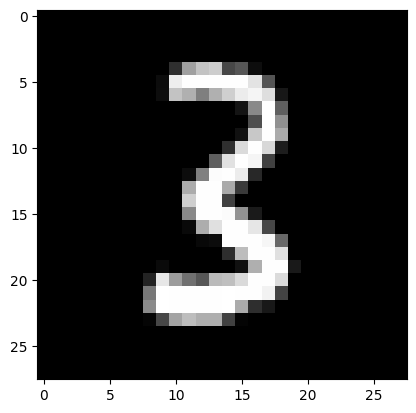

In [ ]:
plt.imshow(xb[0].view(28,28))

In [ ]:
model,opt = get_model()

In [ ]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:  # getting batches
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)


In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.12, 0.96
0.10, 0.98
0.10, 0.96


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(1.))

# Random sampling
we want our training set to be randomized

In [ ]:
import random

In [ ]:
class Sampler():
  def __init__(self, ds, shuffle = False):
    self.n, self.shuffle = len(ds), shuffle

  def __iter__(self):
    res = list(range(self.n))
    # print(f'before:{res}')

    if self.shuffle:
      random.shuffle(res)
    # print(f'Later:{res}')
    return iter(res)

In [ ]:
ss =Sampler(train_ds)
ss

In [ ]:
it = iter(ss)  # calling ___iter__()
list(it)[:5]   # these are indexes

[0, 1, 2, 3, 4]

In [ ]:
from itertools import islice

In [ ]:
list(islice(ss,5)) # first 5

[0, 1, 2, 3, 4]

In [ ]:
s =Sampler(train_ds, True)
list(islice(s,5)) # first 5

[12742, 46844, 44137, 8917, 31082]

In [ ]:
import fastcore.all as fc

## creating batch sampler

In [ ]:
class BatchSampler():  # it will do islice for us
  def __init__(self, sampler, bs, drop_last = False):
    # sampler, bs, drop_last  = self.sampler, self.bs, self.drop_last
    fc.store_attr()

  def __iter__(self):
    yield from fc.chunked(iter(self.sampler), self.bs, drop_last = self.drop_last)




In [ ]:
batchs = BatchSampler( ss, 4)

list(islice(batchs,5))

[[0, 1, 2, 3],
 [4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19]]

In [ ]:
def collate(b):
    xs,ys = zip(*b)  # grab batches,, separate x and y separately and then stack them as tecsors
    return torch.stack(xs),torch.stack(ys)

In [ ]:

tensor1 = torch.tensor([1, 2, 3])
tensor2 = torch.tensor([4, 5, 6])
tensor3 = torch.tensor([7, 8, 9])

# Stack tensors along a new dimension (default is dim=0)
stacked_tensor = torch.stack([tensor1, tensor2, tensor3])

print(stacked_tensor)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


In [ ]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate):
      fc.store_attr()
    def __iter__(self):
      yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [ ]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [ ]:
np.array(list(iter(train_samp))).shape

(1000, 50)

In [ ]:
np.array(list(iter(train_samp)))[0]

array([25251,  3845, 19116, 39767, 14644,  9918,  3684, 25079, 31417, 49284, 13230,  2558,  8351,  9741, 47030, 25894,
       27713, 15091, 37406, 11465, 45328, 28169, 11984, 22914, 43234, 26381, 21018, 42908, 49173, 41235, 47815,  3658,
        6592,  7903, 31382, 35602,  3317, 38432, 39536, 25070, 45335, 36422, 37727, 28774, 41417, 48743, 30712,  1130,
        3160, 42527])

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

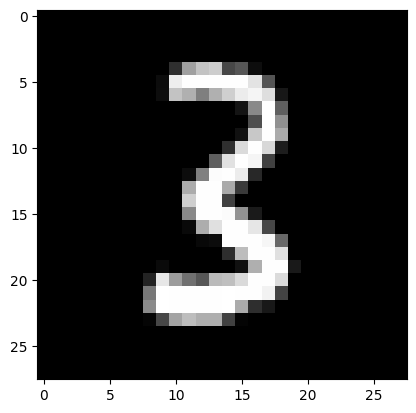

In [ ]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
xb.shape,yb.shape


(torch.Size([50, 784]), torch.Size([50]))

In [ ]:
model,opt = get_model()


In [ ]:
fit()

0.08, 0.98
0.09, 0.98
0.04, 0.98


# Multiprocessing DataLoader
